In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Create simplified model
fwt_panels = 10
main_panels = 20

p = RollRig.base_params(3, panels = fwt_panels*2 + main_panels)  
sm = mf.SymbolicModel.from_file('RollRigModel.py')

In [3]:
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_r.name:0,p.alpha_1.name:sym.atan(sym.sin(p.Lambda)*sym.tan(p.q[1])),
             p.alpha_2.name:sym.atan(sym.sin(p.Lambda)*sym.tan(p.q[2]))})
sm.to_file('tempModel_free.py')

In [4]:
# Add fixed params to dict
params = {}
params['c'] = 0.06
params['g'] = 9.81
params['alpha_r'] = 0
params['c_d_max'] = 1
params['m_w'] = 0.0
params['I_xx_w'] = 0.019480411
params['y_w'] = 0.00198
params['z_w'] = -0.00273
params['c_d_max'] = 0
params['T'] = 0.12
params['V'] = 25
params['alpha_c'] = np.deg2rad(0)

In [5]:
# create lift distribution
def create_lift_dist_from_file(filename,span,sigma,main_panels,fwt_panels):
    s_w = span*(1-sigma)
    delta = s_w / main_panels
    y_panel_main = np.linspace(-s_w/2+delta/2,s_w/2-delta/2,main_panels)

    s_f = span*sigma/2
    delta = s_f / fwt_panels
    y_panel_fwt = np.linspace(delta/2,s_f-delta/2,fwt_panels)+s_w/2
    y_panel = [*-np.flip(y_panel_fwt),*y_panel_main,*y_panel_fwt]

    ## load lift distribution
    df = pd.read_csv(filename)
    y_span = df['y'].to_numpy()/df['span'][0]*span*100
    y_c_l = df['C_l'].to_numpy()

    # interpolate on each panel
    return list(np.interp(np.abs(y_panel),y_span,y_c_l,left=0,right=0))

def create_const_lift_dist(main_panels,fwt_panels):
    return [np.pi*2]*(main_panels+(2*fwt_panels))

def create_tapered_lift_dist(main_panels,fwt_panels):
    val = 2*np.pi
    main_a = [val]*main_panels
    fwt_a = [((i+0.5)/fwt_panels)*val for i in range(fwt_panels)]
    return [*fwt_a,*main_a,*reversed(fwt_a)]

In [6]:
# create configs
attitudes=[]
vs = [15,20,25,30]

spans = np.linspace(0.8,1.5,32)
for span in spans:
    for lam in [10,30]:
        tmp_params = {}
        tmp_params['s'] = span
        tmp_params['sigma'] = (span-0.728)/span
        tmp_params['Lambda'] = np.deg2rad(lam)
        tmp_params['a'] = create_lift_dist_from_file(r'LiftDistribution_aoa_0_rr_60_span_100.csv',span,tmp_params['sigma'],main_panels,fwt_panels)
        tmp_params['m_f'] = 0.05/0.272*tmp_params['sigma']
        tmp_params['l_f'] = 0.0766*np.cos(tmp_params['Lambda'])/0.272*tmp_params['sigma']
        tmp_params['I_xx_f'] = 8.68e-5/0.272**2*tmp_params['sigma']

        attitudes.append(({"Mode":"free"},{**tmp_params}))
jobs=[({**config,},{**params,**config_params,}) for config,config_params in attitudes]

In [7]:
j_i = 20
job = jobs[j_i]
ic = [0,np.deg2rad(120),0,0,0,0]




# Create Numeric Model
nm = mf.NumericModel.from_SymbolicModel(p, sm)


p_vars = vars(p)
for string, value in job[1].items():
    if string in p_vars:
        p_vars[string].value = value

# calcualte coast angles
ic = RollRig.Calc_coast(nm,p,ic)
nm.ExtForces(p.GetNumericTuple(ic,0),ic,0)[0][0]

In [8]:
%%time
res = []

for job in jobs:
    p_vars = vars(p)
    for string, value in job[1].items():
        if string in p_vars:
            p_vars[string].value = value
    # calcualte coast angles
    ic = [0,np.deg2rad(60),0,0,0,0]
    ic = RollRig.Calc_coast(nm,p,ic)

    res.append({**job[1],"t":nm.ExtForces(p.GetNumericTuple(ic,0),ic,0)[0][0]})

CPU times: user 363 ms, sys: 4.23 ms, total: 367 ms
Wall time: 365 ms


<AxesSubplot:xlabel='s', ylabel='t'>

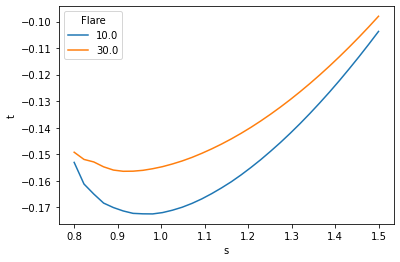

In [9]:
df = pd.DataFrame(res)
df['Flare'] =pd.Categorical(np.round(np.rad2deg(df['Lambda'])))

fig, axs = plt.subplots(1, 1)

sns.lineplot(data=df,x='s',y='t',hue='Flare',ax=axs)

In [10]:
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparisonV2/SpanData.csv', index = False)